In [59]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle
import math
from IPython.display import clear_output
import numpy as np
import re

sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_colwidth', 1024)

In [60]:
model_labels = {
    'gemma-2-2b-it': 'Gemma2-2b-it',
    'gemma-2-9b-it': 'Gemma2-9b-it',
    'llama-3.1-8b-instruct': 'LLaMA-3.1-8b-instruct',
    'qwen2.5-7b-instruct': 'Qwen2.5-7b-it', 
    'tablellama': 'TableLlama'
}

In [61]:
truths = []

paths = ["ws-gemma2b",
        "ws-gemma9b",
        "ws-llama",
        "ws-qwen",
        "ws-tablellama"]

for p in paths:
    print(p)
    with open('./' + p + '/preprocessed.pickle', 'rb') as handle:
        mydict = pickle.load(handle)
    
    truth = mydict['truth']

    model_name = mydict['model_name']
    model_name_short = model_name.split('/')[-1].lower()
    truth['model'] = model_name_short
    truths.append(truth)

ws-gemma2b
ws-gemma9b
ws-llama
ws-qwen
ws-tablellama


In [62]:
del mydict

In [63]:
entros = []

path_mapper = {"ws-gemma2b": 'gemma-2-2b-it', 
          "ws-gemma9b": 'gemma-2-9b-it', 
          "ws-llama": 'llama-3.1-8b-instruct',
          "ws-qwen": 'qwen2.5-7b-instruct',
          "ws-tablellama": 'tablellama'}

for p,v in path_mapper.items():
    print(p)
    with open('./' + p + '/aggrodue.pickle', 'rb') as handle:
        aggrodue = pickle.load(handle)
    
    aggrodue = aggrodue[['pid', 'answers_entropy_norm']]
    aggrodue['model'] = v

    entros.append(aggrodue)

ws-gemma2b
ws-gemma9b
ws-llama
ws-qwen
ws-tablellama


In [64]:
del aggrodue

In [65]:
t = pd.concat(truths)

In [66]:
t.shape

(72420, 6)

In [67]:
t.model.value_counts()

model
llama-3.1-8b-instruct    15020
gemma-2-2b-it            14770
gemma-2-9b-it            14770
qwen2.5-7b-instruct      14330
tablellama               13530
Name: count, dtype: int64

In [68]:
t.hallucinated.sum()

20963

In [69]:
t.model.unique()

array(['gemma-2-2b-it', 'gemma-2-9b-it', 'llama-3.1-8b-instruct',
       'qwen2.5-7b-instruct', 'tablellama'], dtype=object)

Text(0, 0.5, 'Proportion')

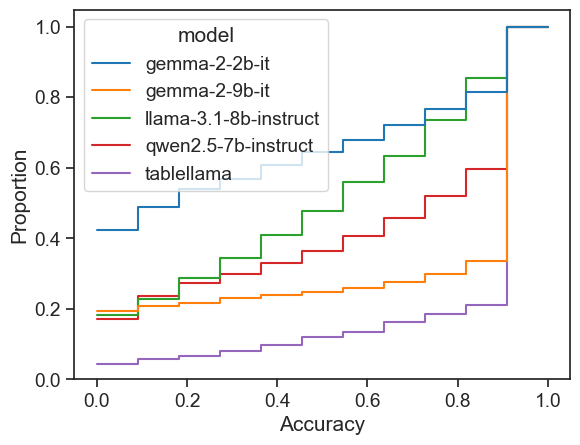

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.25)

from palettable.cartocolors.qualitative import Prism_10, Bold_10

corek = t.groupby(['model', 'pid'], as_index=False).correct.mean()

sns.histplot(
    data=corek, x='correct', hue='model',
    log_scale=False, element="step", fill=False,
    cumulative=True, stat="probability", common_norm=False,
    bins=corek.correct.nunique(), color=Prism_10.mpl_colors
)

plt.xlabel("Accuracy")
plt.ylabel("Proportion")

In [71]:
corek['correct_cat'] = corek['correct'].apply(
    lambda x: '0.0' if x == 0.0 else ('1.0' if x == 1.0 else 'other')
)

collapsed_counts = corek.groupby(['model', 'correct_cat']).size()
collapsed_relative = collapsed_counts / collapsed_counts.groupby(level=0).transform('sum')
collapsed_relative

model                  correct_cat
gemma-2-2b-it          0.0            0.421801
                       1.0            0.184834
                       other          0.393365
gemma-2-9b-it          0.0            0.192282
                       1.0            0.665538
                       other          0.142180
llama-3.1-8b-instruct  0.0            0.182423
                       1.0            0.145140
                       other          0.672437
qwen2.5-7b-instruct    0.0            0.171668
                       1.0            0.402652
                       other          0.425680
tablellama             0.0            0.044346
                       1.0            0.790096
                       other          0.165558
dtype: float64

In [72]:
table_df = collapsed_relative.unstack().fillna(0).reset_index()
table_df.columns.name = None
table_df[['1.0', '0.0', 'other']].round(2)

,1.0,0.0,other
0,0.18,0.42,0.39
1,0.67,0.19,0.14
2,0.15,0.18,0.67
3,0.40,0.17,0.43
4,0.79,0.04,0.17


In [73]:
a = pd.concat(entros)

In [74]:
corek = corek.merge(a, on=['model', 'pid'])

In [75]:
corek

,model,pid,correct,correct_cat,answers_entropy_norm
0,gemma-2-2b-it,0,0.0,0.0,0.635761
1,gemma-2-2b-it,1,0.0,0.0,0.649639
2,gemma-2-2b-it,2,0.4,other,0.665581
3,gemma-2-2b-it,3,0.0,0.0,0.500402
4,gemma-2-2b-it,4,0.7,other,0.470224
...,...,...,...,...,...
7203,tablellama,1794,1.0,1.0,0.000000
7204,tablellama,1795,1.0,1.0,0.000000
7205,tablellama,1798,0.7,other,0.610864
7206,tablellama,1799,1.0,1.0,0.000000


In [76]:
def mylab(x):
    if x.correct == 0.0 and x.answers_entropy_norm == 0.0: return 'awrong_norec'
    if x.correct == 0.0: return 'awrong_rec'
    if x.correct == 1.0: return 'aright'
    return 'mixed'

corek['correct_cat'] = corek.apply(mylab, axis=1)

In [77]:
collapsed_counts = corek.groupby(['model', 'correct_cat']).size()
collapsed_relative = collapsed_counts / collapsed_counts.groupby(level=0).transform('sum')
table_df = collapsed_relative.unstack().fillna(0).reset_index()
table_df.columns.name = None
# table_df[['1.0', '0.0', 'other']].round(2)

In [78]:
table_df

,model,aright,awrong_norec,awrong_rec,mixed
0,gemma-2-2b-it,0.182993,0.057823,0.364626,0.394558
1,gemma-2-9b-it,0.665986,0.101361,0.090476,0.142177
2,llama-3.1-8b-instruct,0.145151,0.010033,0.171906,0.672910
3,qwen2.5-7b-instruct,0.402525,0.021739,0.150771,0.424965
4,tablellama,0.790646,0.029696,0.014848,0.164811


/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_56462/2638544977.py:10: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.histplot(


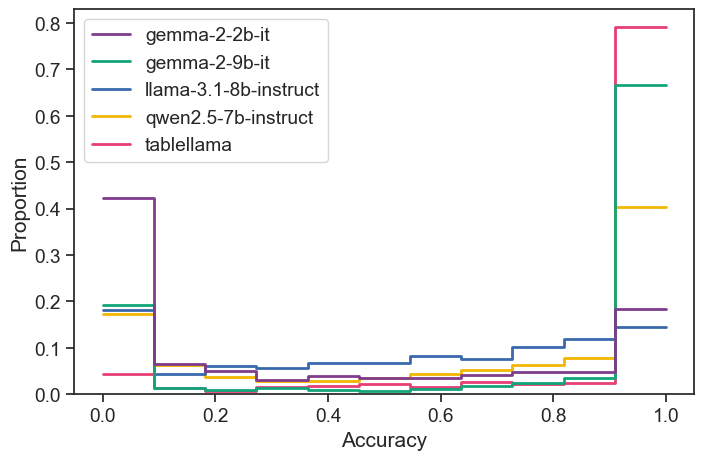

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.25)

from palettable.cartocolors.qualitative import Prism_10, Bold_10

plt.figure(figsize=(8, 5))

sns.histplot(
    data=corek,
    x="correct",
    hue="model",
    stat="probability",
    common_norm=False,
    discrete=False,
    element="step",
    fill=False,
    palette=Bold_10.mpl_colors,
    linewidth=2,
    log_scale=(False, False),
    bins=corek.correct.nunique()
)

plt.xlabel("Accuracy")
plt.ylabel("Proportion")

leg = plt.gca().get_legend()
leg.set_title(None)


plt.savefig("accuracy_distribution_per_model.pdf", format="pdf", bbox_inches="tight", dpi=600)

In [80]:
from palettable.cartocolors.qualitative import Bold_10

palette_used = Bold_10.mpl_colors

model_colors = dict(zip(corek["model"].unique(), palette_used))

# Later, when adding a label, legend, or annotation:
# model_color = model_colors["your_model_name"]

In [81]:
model_colors

{'gemma-2-2b-it': (0.4980392156862745,
  0.23529411764705882,
  0.5529411764705883),
 'gemma-2-9b-it': (0.06666666666666667,
  0.6470588235294118,
  0.4745098039215686),
 'llama-3.1-8b-instruct': (0.2235294117647059,
  0.4117647058823529,
  0.6745098039215687),
 'qwen2.5-7b-instruct': (0.9490196078431372,
  0.7176470588235294,
  0.00392156862745098),
 'tablellama': (0.9058823529411765, 0.24705882352941178, 0.4549019607843137)}

## progressive window (all models)

In [82]:
!ls */prog_*.pickle

ws-gemma2b/prog_gemma-2-2b-it.pickle
ws-gemma9b/prog_gemma-2-9b-it.pickle
ws-llama/prog_llama-3.1-8b-instruct.pickle
ws-qwen/prog_qwen2.5-7b-instruct.pickle
ws-tablellama/prog_tablellama.pickle


In [83]:
wd = {
    "gemma-2-2b-it": "ws-gemma2b/prog_gemma-2-2b-it.pickle", 
    "gemma-2-9b-it": "ws-gemma9b/prog_gemma-2-9b-it.pickle", 
    "llama-3.1-8b-instruct": "ws-llama/prog_llama-3.1-8b-instruct.pickle",
    "qwen2.5-7b-instruct": "ws-qwen/prog_qwen2.5-7b-instruct.pickle", 
    "tablellama": "ws-tablellama/prog_tablellama.pickle"
}


for k, w in wd.items():
    with open(w, 'rb') as handle:
        wd[k] = pickle.load(handle)

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_56462/2185289263.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog__["c_norm"] = prog__["c"] / maxc
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_56462/2185289263.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog__["mae_smooth"] = smooth_data(prog_, "mae", window=15)
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_56462/2185289263.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

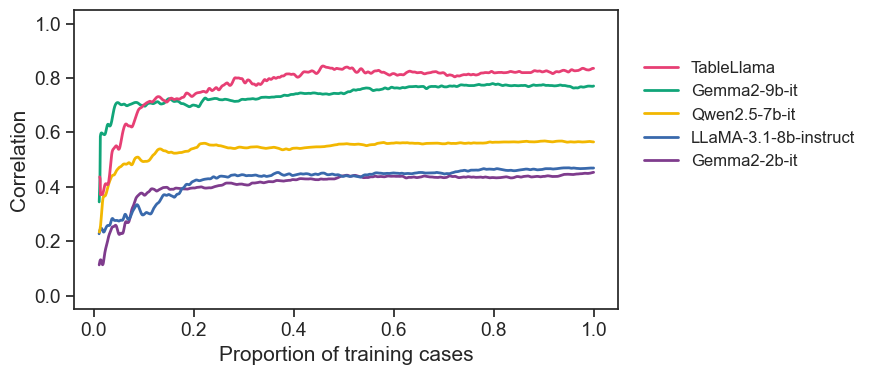

In [84]:
def smooth_data(df, column, window=10):
    return df.groupby("i")[column].transform(lambda x: x.rolling(window, win_type="gaussian").mean(std=3))


import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.25)

plt.figure(figsize=(9, 4))

for model_name, prog_ in wd.items():
    maxc = prog_.c.max()
    prog__ = prog_[prog_.c < maxc]
    
    prog__["c_norm"] = prog__["c"] / maxc
    prog__["mae_smooth"] = smooth_data(prog_, "mae", window=15)
    prog__["r2_smooth"] = smooth_data(prog_, "r2", window=15)
    prog__["spearman_smooth"] = smooth_data(prog_, "spearman_corr", window=15)
    
    color = model_colors[model_name]
    sns.lineplot(prog__, x="c_norm", y="spearman_smooth", errorbar=None, linewidth=2, label=model_name, color=color)

plt.xlabel("Proportion of training cases")
plt.ylabel("Correlation")
plt.ylim(-0.05, 1.05)
# plt.legend(title="", frameon=False, fontsize=12, title_fontsize=10)

handles, labels = plt.gca().get_legend_handles_labels()


desired_order = ['tablellama', 'gemma-2-9b-it', 'qwen2.5-7b-instruct', 'llama-3.1-8b-instruct', 'gemma-2-2b-it']

sorted_handles = [handles[labels.index(name)] for name in desired_order]
sorted_labels = [model_labels[labels[labels.index(name)]] for name in desired_order]

plt.legend(
    sorted_handles, sorted_labels,
    title="",
    frameon=False,
    fontsize=12,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.02, 0.65)  
)

plt.tight_layout()

plt.savefig('progressive_training_all.pdf', format="pdf", bbox_inches="tight", dpi=600)

### performance graph, for all models

In [85]:
!ls */resu*.pickle

ws-gemma2b/resugemma-2-2b-it.pickle
ws-gemma9b/resugemma-2-9b-it.pickle
ws-llama/resullama-3.1-8b-instruct.pickle
ws-qwen/resuqwen2.5-7b-instruct.pickle
ws-tablellama/resutablellama.pickle


In [86]:
wd = {
    "gemma-2-2b-it": "ws-gemma2b/resugemma-2-2b-it.pickle", 
    "gemma-2-9b-it": "ws-gemma9b/resugemma-2-9b-it.pickle", 
    "llama-3.1-8b-instruct": "ws-llama/resullama-3.1-8b-instruct.pickle",
    "qwen2.5-7b-instruct": "ws-qwen/resuqwen2.5-7b-instruct.pickle", 
    "tablellama": "ws-tablellama/resutablellama.pickle"
}


for k, w in wd.items():
    with open(w, 'rb') as handle:
        wd[k] = pickle.load(handle)

In [87]:
resu = wd["tablellama"]

### "dati giusti" qua sotto

In [88]:
resu.keys()

dict_keys([('generated', 'pe_rao_trans_s_norm'), ('generated', 'answers_entropy_norm'), ('generated_kl', 'answers_entropy_norm'), ('postilla', 'answers_entropy_norm'), ('postilla_reconciled', 'answers_entropy_norm'), ('postilla_kl', 'answers_entropy_norm'), ('postilla_kl_reconciled', 'answers_entropy_norm')])

In [89]:
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]

In [90]:
myds

,run,pid,true_ent_1,true_ent_2,true_ent_3,true_ent_4,true_ent_5,true_ent_6,true_ent_7,true_ent_8,...,maxp_6,maxp_7,maxp_8,maxp_9,correct,hallucinated,answers_entropy_norm,correct_mean,perplexity_l,count
0,0,0,0.538028,4.653403e-02,1.665666e-06,0.000120,1.130083e-06,6.803319e-01,2.014953e-08,1.882797e-06,...,0.770059,1.000000,1.000000,0.999867,True,False,0.673012,0.6,1.000003,6
1,1,0,0.538028,4.653403e-02,1.665666e-06,0.000120,1.130083e-06,6.803319e-01,1.940029e-05,2.464039e-03,...,0.770059,0.999999,0.999735,1.000000,False,False,0.673012,0.6,1.000003,4
10,0,1,0.011628,1.844640e-04,5.849231e-04,0.000390,2.845197e-09,4.421126e-07,8.410199e-05,6.745654e-04,...,1.000000,0.999995,0.999947,1.000000,True,False,0.000000,1.0,1.000001,10
20,0,2,0.003763,7.357106e-05,1.093485e-06,0.002849,6.398668e-05,4.854595e-08,4.177585e-07,8.158656e-06,...,1.000000,1.000000,1.000000,1.000000,True,False,0.000000,1.0,1.0,10
30,0,3,0.001256,9.439888e-09,4.918854e-07,0.001006,6.446186e-07,3.043880e-07,2.491019e-06,7.806169e-06,...,1.000000,1.000000,1.000000,1.000000,True,False,0.000000,1.0,1.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13430,0,1795,0.007699,4.669020e-08,4.013911e-04,0.000575,3.527765e-07,2.503352e-09,4.805182e-07,7.712510e-04,...,1.000000,1.000000,0.999930,0.999999,True,False,0.000000,1.0,1.0,10
13440,0,1798,0.557201,7.230116e-07,3.279528e-04,0.000003,1.073667e-06,1.674956e-07,8.254165e-09,9.034461e-07,...,1.000000,1.000000,1.000000,0.998663,True,False,0.610864,0.7,1.0,7
13444,4,1798,0.557201,3.765475e-04,5.221379e-05,0.000335,4.084044e-07,5.886511e-07,9.214883e-09,8.462966e-07,...,1.000000,1.000000,1.000000,0.999971,False,False,0.610864,0.7,1.0,3
13450,0,1799,0.001690,2.147213e-04,1.573576e-05,0.000152,2.394102e-06,2.956477e-07,3.246071e-09,9.464648e-07,...,1.000000,1.000000,1.000000,0.999987,True,False,0.000000,1.0,1.0,10


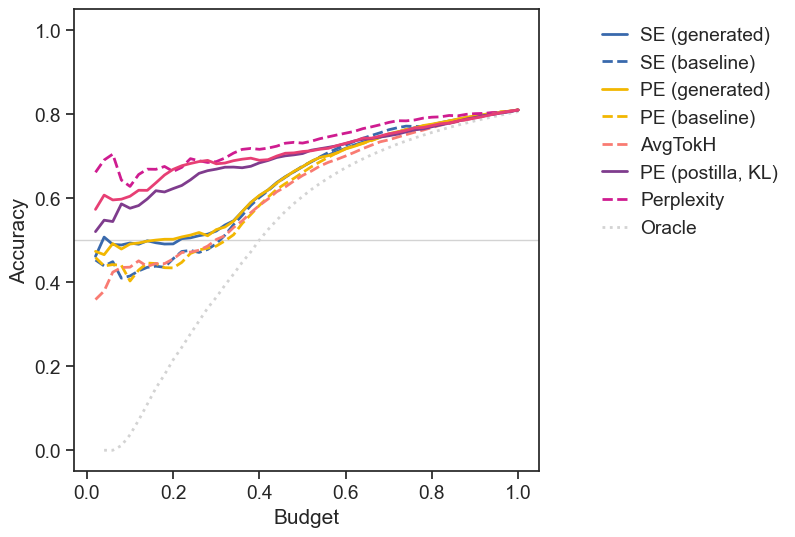

In [91]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.25)
plt.figure(figsize=(6, 6))

nbins=50
palette = Bold_10.mpl_colors

plt.axhline(y=0.5, color='lightgrey', linewidth=1, zorder=0, linestyle='-')

############ SE, generated, no kl
target = 'pe_rao_trans_s_norm' # SE

# sono tutti "dati allineati" come numeri di casi
# ground truth (target), prediction, l'accuracy media è >=.5?, i casi analizzati con la loro correttezza e accuracy media
# correct_mean
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE (generated)", color=palette[2], linewidth=2, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="SE (baseline)", color=palette[2], linewidth=2, linestyle='--')

# baseline (true accuracy)
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

accu = myds.correct_mean.sort_values()
correct_mean_thr = correct_mean_thr.loc[accu.index]

unsure_count = list(reversed([(correct_mean_thr[:b]).mean() for b in bs]))

ax = sns.lineplot(x=bs_, y=unsure_count, label="Oracle", color='lightgrey', linewidth=2, linestyle=':')

############ entropy, generated, no kl
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (generated)", color=palette[3], linewidth=2, linestyle='-')

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (baseline)", color=palette[3], linewidth=2, linestyle='--')


# perplexity as a baseline
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

perp = myds.perplexity_l.sort_values()
y_res = y_res.loc[perp.index]
correct_mean_thr = correct_mean_thr.loc[perp.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="Perplexity", color=palette[8], linewidth=2, linestyle='--')

# average toek entropy as a baseline
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

avent = myds[['true_ent_' + str(i) for i in range(1,10)]].max(axis=1).sort_values()
y_res = y_res.loc[avent.index]
correct_mean_thr = correct_mean_thr.loc[avent.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="AvgTokH", color=palette[9], linewidth=2, linestyle='--')


############ entropy, postilla, kl
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('postilla_kl_reconciled', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (postilla, KL)", color=palette[0], 
                  linewidth=2, linestyle='-')

############ entropy, postilla, kl
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('postilla_reconciled', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (postilla)", color=palette[4], 
                  linewidth=2, linestyle='-')


########
plt.ylim(-0.05,1.05)
plt.xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.])

plt.xlabel("Budget")
plt.ylabel("Accuracy")

handles1, labels1 = plt.gca().get_legend_handles_labels()

handles1 = [handles1[i] for i in [0,1,3,4,6,7,5,2]]
labels1 = [labels1[i] for i in [0,1,3,4,6,7,5,2]]

plt.legend(
    handles=handles1,
    title="",
    loc="upper right",
    bbox_to_anchor=(1.55, 1),
    frameon=False,
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.7,
     handlelength=1.3
)

plt.savefig("budget_and_baseline_mean_postilla_single_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

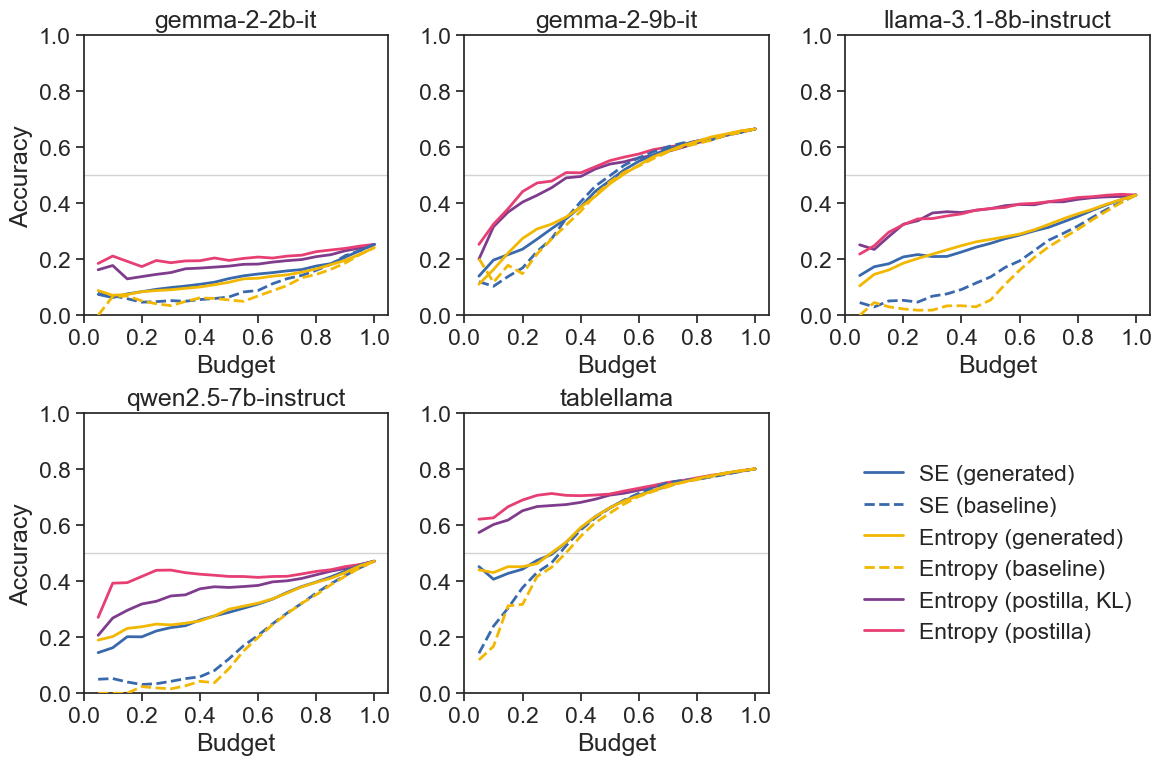

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
axs = axs.flatten()

nbins = 20

model_names = list(wd.keys()) 
palette = Bold_10.mpl_colors

for i, model_name in enumerate(model_names):
    ax = axs[i]
    resu = wd[model_name]

    ax.axhline(y=0.5, color='lightgrey', linewidth=1, zorder=0, linestyle='-')

    ################## SE (generated)
    target = 'pe_rao_trans_s_norm'
    y_res, pred, correct_mean_thr, _ = resu[('generated', target)]

    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]
    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    sns.lineplot(x=bs_, y=unsure_count, label="SE (generated)", color=palette[2], linewidth=2, linestyle='-', ax=ax, zorder=10)
    delta = unsure_count[0]
    
    # baseline (true variability)
    bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    y_res = y_res.sort_values()
    correct_mean_thr = correct_mean_thr.loc[y_res.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]
    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    sns.lineplot(x=bs_, y=unsure_count, label="SE (baseline)", color=palette[2], linewidth=2, linestyle='--', ax=ax, zorder=10)


    ################## Entropy (generated)
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr, _ = resu[('generated', target)]
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]
    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    sns.lineplot(x=bs_, y=unsure_count, label="Entropy (generated)", color=palette[3], linewidth=2, linestyle='-', ax=ax, zorder=10)

    # baseline (true variability)
    bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    y_res = y_res.sort_values()
    correct_mean_thr = correct_mean_thr.loc[y_res.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]
    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    sns.lineplot(x=bs_, y=unsure_count, label="Entropy (baseline)", color=palette[3], linewidth=2, linestyle='--', ax=ax, zorder=10)


    ################## Postilla + KL
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr, _ = resu[('postilla_kl', target)]
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]
    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget
    
    delta2 = unsure_count[0] - delta
    sns.lineplot(x=bs_, y=unsure_count-delta2, label="Entropy (postilla, KL)", color=palette[0], 
                      linewidth=2, linestyle='-', ax=ax)

    ################## Postilla
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr, _ = resu[('postilla', target)]
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]
    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    sns.lineplot(x=bs_, y=unsure_count-delta2, label="Entropy (postilla)", color=palette[4], 
                      linewidth=2, linestyle='-', ax=ax)

    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.])
    ax.set_xlabel("Budget")
    if i % 3 == 0:
        ax.set_ylabel("Accuracy")
    else:
        ax.set_ylabel("")
    ax.set_title(model_name)
    ax.get_legend().remove()
    ax.tick_params(labelleft=True)

# Sixth subplot (legend only)
axs[5].axis("off")
handles, labels = axs[0].get_legend_handles_labels()
axs[5].legend(
    handles=handles,
    labels=labels,
    frameon=False,
    loc="center",
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.7,
    handlelength=1.7
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.35)

# plt.savefig("budget_and_baseline_mean_all.pdf", format="pdf", bbox_inches="tight", dpi=600)

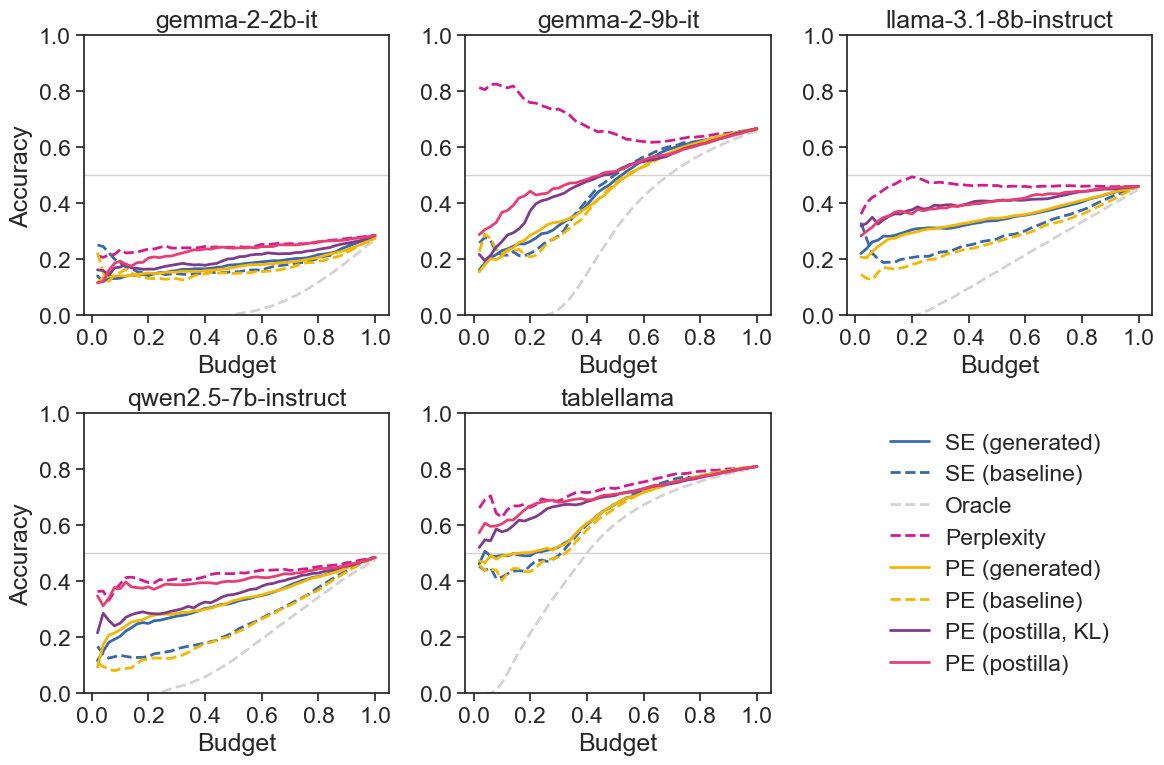

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
axs = axs.flatten()

nbins = 50

model_names = list(wd.keys()) 
palette = Bold_10.mpl_colors

for i, model_name in enumerate(model_names):
    ax = axs[i]
    resu = wd[model_name]
    

    ax.axhline(y=0.5, color='lightgrey', linewidth=1, zorder=0, linestyle='-')

    ### SE, generated, no kl
    target = 'pe_rao_trans_s_norm'
    y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
    correct_mean_thr = myds.correct_mean

    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget
    delta = unsure_count[0]

    ax = sns.lineplot(x=bs_, y=unsure_count, label="SE (generated)", color=palette[2], linewidth=2, linestyle='-', ax=ax)

    # baseline (true variability)
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    y_res = y_res.sort_values()
    correct_mean_thr = correct_mean_thr.loc[y_res.index]

    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    ax = sns.lineplot(x=bs_, y=unsure_count, label="SE (baseline)", color=palette[2], linewidth=2, linestyle='--', ax=ax)

    # baseline (true accuracy)
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    accu = myds.correct_mean.sort_values()
    correct_mean_thr = correct_mean_thr.loc[accu.index]

    unsure_count = list(reversed([(correct_mean_thr[:b]).mean() for b in bs]))

    ax = sns.lineplot(x=bs_, y=unsure_count, label="Oracle", color='lightgrey', linewidth=2, linestyle='--', ax=ax)
 
    # perplexity as a baseline
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    perp = myds.perplexity_l.sort_values()
    y_res = y_res.loc[perp.index]
    correct_mean_thr = correct_mean_thr.loc[perp.index]

    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    ax = sns.lineplot(x=bs_, y=unsure_count, label="Perplexity", color=palette[8], linewidth=2, linestyle='--', ax=ax)

    
    ### entropy, generated, no kl
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
    correct_mean_thr = myds.correct_mean

    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (generated)", color=palette[3], linewidth=2, linestyle='-', ax=ax)

    # baseline (true variability)
    bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    y_res = y_res.sort_values()
    correct_mean_thr = correct_mean_thr.loc[y_res.index]

    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (baseline)", color=palette[3], linewidth=2, linestyle='--', ax=ax)

    ### entropy, postilla, kl
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr, myds = resu[('postilla_kl_reconciled', target)]
    correct_mean_thr = myds.correct_mean

    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget
    delta2 = unsure_count[0] - delta
    
    ax = sns.lineplot(x=bs_, y=unsure_count-delta2, label="PE (postilla, KL)", color=palette[0], 
                      linewidth=2, linestyle='-', ax=ax)

    ### entropy, postilla, no kl
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr, myds = resu[('postilla_reconciled', target)]
    correct_mean_thr = myds.correct_mean

    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    unsure_count = [(correct_mean_thr[b:]).mean() for b in bs] # how many unsure in the selected budget

    ax = sns.lineplot(x=bs_, y=unsure_count, label="PE (postilla)", color=palette[4], 
                      linewidth=2, linestyle='-', ax=ax)


    ########
    plt.ylim(-0.05,1.05)
    plt.xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.])

    plt.xlabel("Budget")
    plt.ylabel("Accuracy")

    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.])
    ax.set_xlabel("Budget")
    if i % 3 == 0:
        ax.set_ylabel("Accuracy")
    else:
        ax.set_ylabel("")
    ax.set_title(model_name)
    ax.get_legend().remove()
    ax.tick_params(labelleft=True)

# Sixth subplot (legend only)
axs[5].axis("off")
handles, labels = axs[0].get_legend_handles_labels()

#handles = [handles1[i] for i in [0,1,2,3,4,5,6,7]]
#labels = [labels1[i] for i in [0,1,2,3,4,5,6,7]]


axs[5].legend(
    handles=handles,
    labels=labels,
    frameon=False,
    loc="center",
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.7,
    handlelength=1.7
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig("budget_and_baseline_mean_all.pdf", format="pdf", bbox_inches="tight", dpi=600)


In [94]:
resu.keys()

dict_keys([('generated', 'pe_rao_trans_s_norm'), ('generated', 'answers_entropy_norm'), ('generated_kl', 'answers_entropy_norm'), ('postilla', 'answers_entropy_norm'), ('postilla_reconciled', 'answers_entropy_norm'), ('postilla_kl', 'answers_entropy_norm'), ('postilla_kl_reconciled', 'answers_entropy_norm')])

In [95]:
(y_res, pred, correct_mean_thr, ds) = resu[('generated', 'answers_entropy_norm')]

In [96]:
y_res.corr(pd.Series(pred))

-0.046750886211106644

In [97]:
ds.answers_entropy_norm.corr(pd.Series(pred))

-0.04716366318378817

### accuracy after correction

In [402]:
# original

def correctme(correct_mean_thr, rev = False):
    ooo = []
  
    for b in bs:
        cm = correct_mean_thr.copy()
        if rev:
            cm.iloc[:b] = True
        else:
            cm.iloc[b:] = True
        ooo.append(cm.mean())
    if rev: ooo = list(reversed(ooo))
    return ooo

In [388]:
resu = wd['gemma-2-2b-it']

In [389]:
target = 'pe_rao_trans_s_norm' # SE

# sono tutti "dati allineati" come numeri di casi
# ground truth (target), prediction, l'accuracy media è >=.5?, i casi analizzati con la loro correttezza e accuracy media
# correct_mean
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

correctme(correct_mean_thr)

[1.0,
 0.993812983360675,
 0.9876728380595265,
 0.980524958987579,
 0.9726271385048043,
 0.9645418326693227,
 0.9570892898992266,
 0.9510428872744316,
 0.9385985469885165,
 0.9256151863135691,
 0.9117178345441762,
 0.9010546051089758,
 0.8890555425357394,
 0.8746894773845794,
 0.8592922427935319,
 0.8449027419732834,
 0.8309116475275369,
 0.8167565033981721,
 0.8003749707054139,
 0.7856339348488401,
 0.7707522849777363,
 0.7557768924302791,
 0.7405671431919384,
 0.7256620576517462,
 0.7107335364424658,
 0.6951253808296229,
 0.6794937895476919,
 0.6658307944691825,
 0.6500351535036332,
 0.6347082259198505,
 0.6187485352706826,
 0.6020154675415991,
 0.5855401921724874,
 0.5694633231778777,
 0.552659948441529,
 0.5373798921959233,
 0.5210217951722533,
 0.5055073822357641,
 0.48868057183032676,
 0.47262713850480537,
 0.45683149753925584,
 0.43904382470119613,
 0.42233419264120076,
 0.40527302554487993,
 0.38853995781579614,
 0.3719475041012424,
 0.35479259432856813,
 0.33737989219592207,
 

In [390]:
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]
correctme(correct_mean_thr)

[1.0,
 0.9916334661354582,
 0.9877900164049683,
 0.9782048277478322,
 0.9692992734942583,
 0.9615420670260135,
 0.9572299039137567,
 0.9517693930161706,
 0.9461213967658777,
 0.9325521443637216,
 0.9227091633466132,
 0.9116475275369108,
 0.8999765643309112,
 0.885938598546988,
 0.8711272556831492,
 0.8572064682446677,
 0.8430981954534797,
 0.8286618232950548,
 0.8138739161003044,
 0.8005858917272087,
 0.7883290367940003,
 0.7711506913522381,
 0.7545348019685963,
 0.7389735176939305,
 0.7242793531755338,
 0.7073822357628317,
 0.6913756737754869,
 0.6750410124209053,
 0.6582376376845566,
 0.6409655495664409,
 0.6252402156081563,
 0.608249355519101,
 0.5921490508554028,
 0.5754159831263194,
 0.5583782516990874,
 0.5406374501992046,
 0.5238106397937676,
 0.5074759784391858,
 0.48936020623388915,
 0.47225216779939166,
 0.45573002109210303,
 0.437778298570425,
 0.4202484180923374,
 0.4018045465198037,
 0.38457932973986453,
 0.36644012186547953,
 0.349191469416452,
 0.3319193812983363,
 0.315

In [391]:
ccc=correct_mean_thr.copy()
correct_mean_thr.iloc[:bs[0]]

Series([], Name: correct_mean, dtype: float64)

In [392]:
bs

[0,
 85,
 170,
 256,
 341,
 426,
 512,
 597,
 682,
 768,
 853,
 938,
 1024,
 1109,
 1194,
 1280,
 1365,
 1450,
 1536,
 1621,
 1706,
 1792,
 1877,
 1962,
 2048,
 2133,
 2218,
 2304,
 2389,
 2474,
 2560,
 2645,
 2730,
 2816,
 2901,
 2986,
 3072,
 3157,
 3242,
 3328,
 3413,
 3498,
 3584,
 3669,
 3754,
 3840,
 3925,
 4010,
 4096,
 4181]

In [393]:
accu = myds.correct_mean.sort_values()
correct_mean_thr = correct_mean_thr.loc[accu.index]

In [394]:
correctme(correct_mean_thr, rev=True)

[1.0,
 1.0,
 1.0,
 1.0,
 0.9991563159128201,
 0.9971408483712236,
 0.9941410827279172,
 0.9901570189829009,
 0.9854230138270548,
 0.9794469182095213,
 0.9726974455120728,
 0.9646355753456779,
 0.9559878134520745,
 0.9460276540895247,
 0.9354347316615899,
 0.923482540426532,
 0.9114834778532973,
 0.8973752050621128,
 0.8834309819545467,
 0.8675181626435519,
 0.8513944223107617,
 0.8354581673306783,
 0.8180689008671186,
 0.7999296929927319,
 0.7820014061401405,
 0.764073119287549,
 0.7449496133114658,
 0.7250292945863583,
 0.7051089758612588,
 0.6849543004452756,
 0.665033981720177,
 0.6451136629950839,
 0.6249589875790978,
 0.6050386688539927,
 0.5851183501288931,
 0.56496367471291,
 0.5450433559878104,
 0.5251230372627108,
 0.5049683618467374,
 0.48504804312163596,
 0.4651277243965331,
 0.44497304898055146,
 0.42505273025545504,
 0.40513241153035545,
 0.3849777361143691,
 0.3650574173892712,
 0.3451370986641691,
 0.32498242324818183,
 0.3050621045230825,
 0.2851417857979831]

In [395]:
ccc=correct_mean_thr.copy()
correct_mean_thr.iloc[:bs[0]]


Series([], Name: correct_mean, dtype: float64)

0.2851417857979845


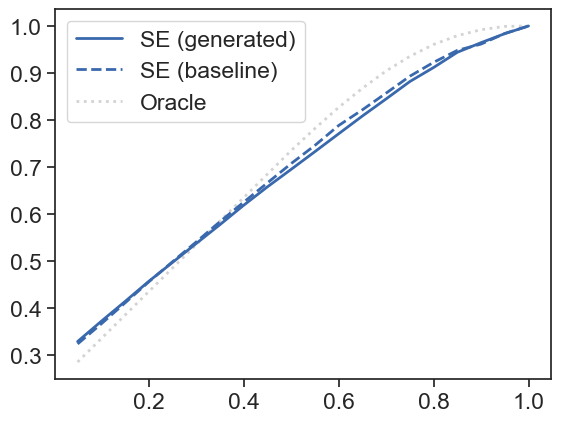

In [403]:
target = 'pe_rao_trans_s_norm' # SE

# sono tutti "dati allineati" come numeri di casi
# ground truth (target), prediction, l'accuracy media è >=.5?, i casi analizzati con la loro correttezza e accuracy media
# correct_mean
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

print(correct_mean_thr.mean())
ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="SE (generated)", color=palette[2], 
                  linewidth=lw, linestyle='-', zorder=10)

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="SE (baseline)", color=palette[2], 
                  linewidth=lw, linestyle='--', zorder=10)

# baseline (true accuracy)
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

accu = myds.correct_mean.sort_values()
correct_mean_thr = correct_mean_thr.loc[accu.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr, rev=True), label="Oracle", color='lightgrey', 
                  linewidth=lw, linestyle=':')

In [404]:
pred.shape, myds.shape, accu.shape

((4267,), (4267, 25), (4267,))

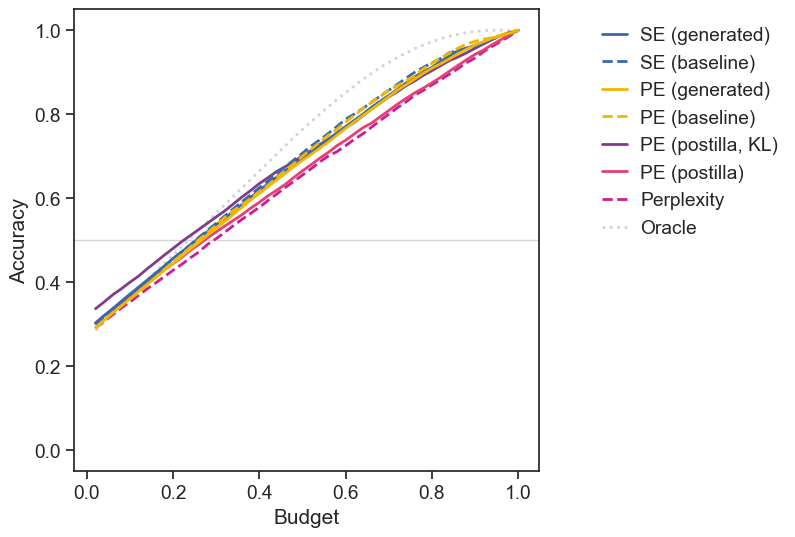

In [405]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.25)
plt.figure(figsize=(6, 6))

nbins=50
palette = Bold_10.mpl_colors
lw=2

plt.axhline(y=0.5, color='lightgrey', linewidth=1, zorder=0, linestyle='-')

############ SE, generated, no kl
target = 'pe_rao_trans_s_norm' # SE

# sono tutti "dati allineati" come numeri di casi
# ground truth (target), prediction, l'accuracy media è >=.5?, i casi analizzati con la loro correttezza e accuracy media
# correct_mean
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="SE (generated)", color=palette[2], 
                  linewidth=lw, linestyle='-', zorder=10)

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="SE (baseline)", color=palette[2], 
                  linewidth=lw, linestyle='--', zorder=10)

# baseline (true accuracy)
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

accu = myds.correct_mean.sort_values()
correct_mean_thr = correct_mean_thr.loc[accu.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr, rev=True), label="Oracle", color='lightgrey', 
                  linewidth=lw, linestyle=':')

############ entropy, generated, no kl
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="PE (generated)", color=palette[3], 
                  linewidth=lw, linestyle='-', zorder=10)

# baseline (true variability)
bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

y_res = y_res.sort_values()
correct_mean_thr = correct_mean_thr.loc[y_res.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="PE (baseline)", color=palette[3], 
                  linewidth=lw, linestyle='--', zorder=10)


# perplexity as a baseline
bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

perp = myds.perplexity_l.sort_values()
y_res = y_res.loc[perp.index]
correct_mean_thr = correct_mean_thr.loc[perp.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="Perplexity", color=palette[8], 
                  linewidth=lw, linestyle='--')


############ entropy, postilla, kl
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('postilla_kl_reconciled', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="PE (postilla, KL)", color=palette[0], 
                  linewidth=lw, linestyle='-')

############ entropy, postilla, kl
target='answers_entropy_norm'
y_res, pred, correct_mean_thr, myds = resu[('postilla_reconciled', target)]
correct_mean_thr = myds.correct_mean

bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
bs_ = [1-np.round(b / len(pred), 2) for b in bs]

# sort all by predicted
pred = pd.Series(pred, index=y_res.index, name='pred')
pred = pred.sort_values()
y_res = y_res.loc[pred.index]
correct_mean_thr = correct_mean_thr.loc[pred.index]

ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="PE (postilla)", color=palette[4], 
                  linewidth=lw, linestyle='-')



########
plt.ylim(-0.05,1.05)
plt.xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.])

plt.xlabel("Budget")
plt.ylabel("Accuracy")

handles1, labels1 = plt.gca().get_legend_handles_labels()

handles1 = [handles1[i] for i in [0,1,3,4,6,7,5,2]]
labels1 = [labels1[i] for i in [0,1,3,4,6,7,5,2]]

plt.legend(
    handles=handles1,
    title="",
    loc="upper right",
    bbox_to_anchor=(1.55, 1),
    frameon=False,
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.7,
     handlelength=1.3
)

plt.savefig("budget_and_baseline_mean_postilla_global_" + model_name_short + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

In [408]:
# original

def correctme(correct_mean_thr, bs, rev = False):
    ooo = []
  
    for b in bs:
        cm = correct_mean_thr.copy()
        if rev:
            cm.iloc[:b] = True
        else:
            cm.iloc[b:] = True
        ooo.append(cm.mean())
    if rev: ooo = list(reversed(ooo))
    return ooo

In [410]:
# original

def correctme(correct_mean_thr, bs, rev = False):
    ooo = []
    bz = bs
    if rev: 
        dd=bs[1]
        bz = [i+dd for i in bs]
        
    for b in bz:
        cm = correct_mean_thr.copy()
        if rev:
            cm.iloc[:b] = True
        else:
            cm.iloc[b:] = True
        ooo.append(cm.mean())
    if rev: ooo = list(reversed(ooo))
    return ooo

gemma-2-2b-it
gemma-2-9b-it
llama-3.1-8b-instruct
qwen2.5-7b-instruct
tablellama


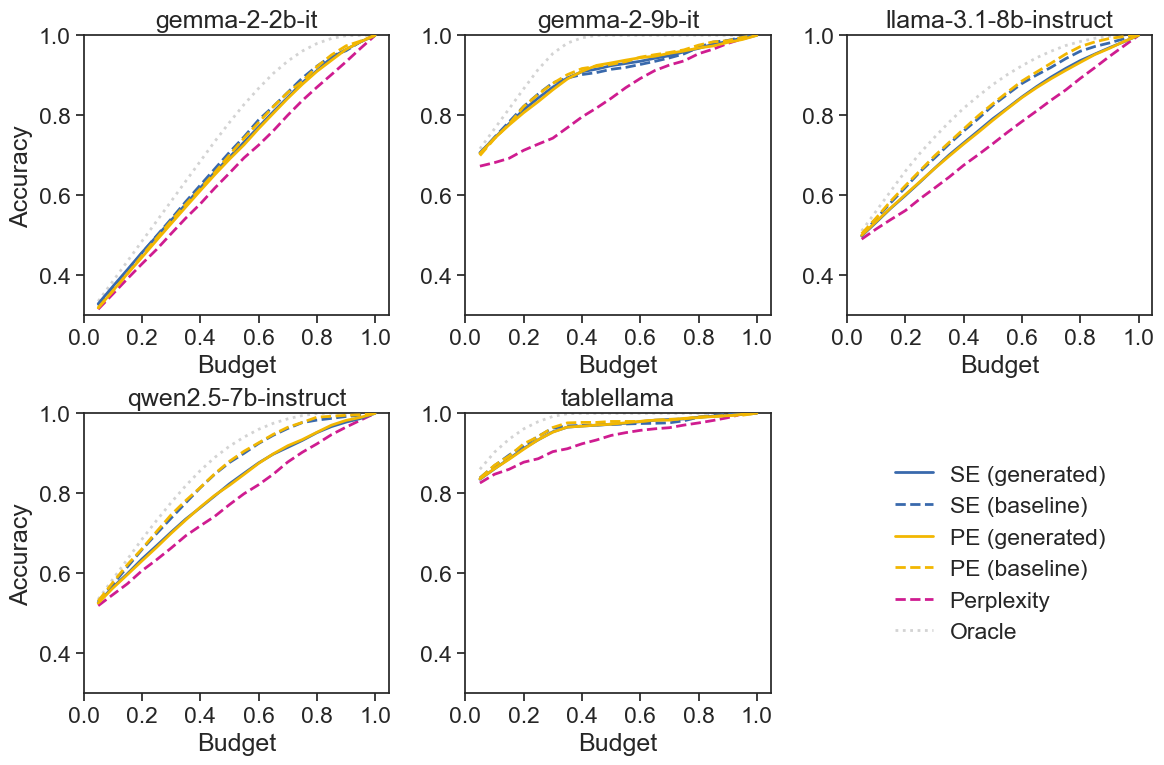

In [416]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
axs = axs.flatten()

nbins = 20

model_names = list(wd.keys()) 
palette = Bold_10.mpl_colors

for i, model_name in enumerate(model_names):
    
    print(model_name)
    ax = axs[i]
    resu = wd[model_name]

    # plt.axhline(y=0.5, color='lightgrey', linewidth=1, zorder=0, linestyle='-')

    ############ SE, generated, no kl
    target = 'pe_rao_trans_s_norm' # SE

    # sono tutti "dati allineati" come numeri di casi
    # ground truth (target), prediction, l'accuracy media è >=.5?, i casi analizzati con la loro correttezza e accuracy media
    # correct_mean
    y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
    correct_mean_thr = myds.correct_mean

    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr, bs), label="SE (generated)", color=palette[2], 
                      linewidth=lw, linestyle='-', zorder=10, ax=ax)

    # baseline (true variability)
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    y_res = y_res.sort_values()
    correct_mean_thr = correct_mean_thr.loc[y_res.index]

    ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr, bs), label="SE (baseline)", color=palette[2], 
                      linewidth=lw, linestyle='--', zorder=10, ax=ax)

    # baseline (true accuracy)
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    accu = myds.correct_mean.sort_values()
    correct_mean_thr = correct_mean_thr.loc[accu.index]

    ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr, bs, rev=True), label="Oracle", color='lightgrey', 
                      linewidth=lw, linestyle=':', ax=ax)

    ############ entropy, generated, no kl
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr, myds = resu[('generated', target)]
    correct_mean_thr = myds.correct_mean

    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr, bs), label="PE (generated)", color=palette[3], 
                      linewidth=lw, linestyle='-', zorder=10, ax=ax)

    # baseline (true variability)
    bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    y_res = y_res.sort_values()
    correct_mean_thr = correct_mean_thr.loc[y_res.index]

    ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr, bs), label="PE (baseline)", color=palette[3], 
                      linewidth=lw, linestyle='--', zorder=10, ax=ax)


    # perplexity as a baseline
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    perp = myds.perplexity_l.sort_values()
    y_res = y_res.loc[perp.index]
    correct_mean_thr = correct_mean_thr.loc[perp.index]

    ax = sns.lineplot(x=bs_, y=correctme(correct_mean_thr, bs), label="Perplexity", color=palette[8], 
                      linewidth=lw, linestyle='--', ax=ax)

    ########

    ax.set_ylim(0.3, 1)
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.])
    ax.set_xlabel("Budget")
    if i % 3 == 0:
        ax.set_ylabel("Accuracy")
    else:
        ax.set_ylabel("")
    ax.set_title(model_name)
    ax.get_legend().remove()
    ax.tick_params(labelleft=True)

# Sixth subplot (legend only)
axs[5].axis("off")
handles, labels = axs[0].get_legend_handles_labels()

handles = [handles[i] for i in [0,1,3,4,5,2]]
labels = [labels[i] for i in [0,1,3,4,5,2]]

axs[5].legend(
    handles=handles,
    labels=labels,
    frameon=False,
    loc="center",
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.7,
    handlelength=1.7
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig("budget_and_baseline_mean_all_corrected.pdf", format="pdf", bbox_inches="tight", dpi=600)

ValueError: too many values to unpack (expected 3)

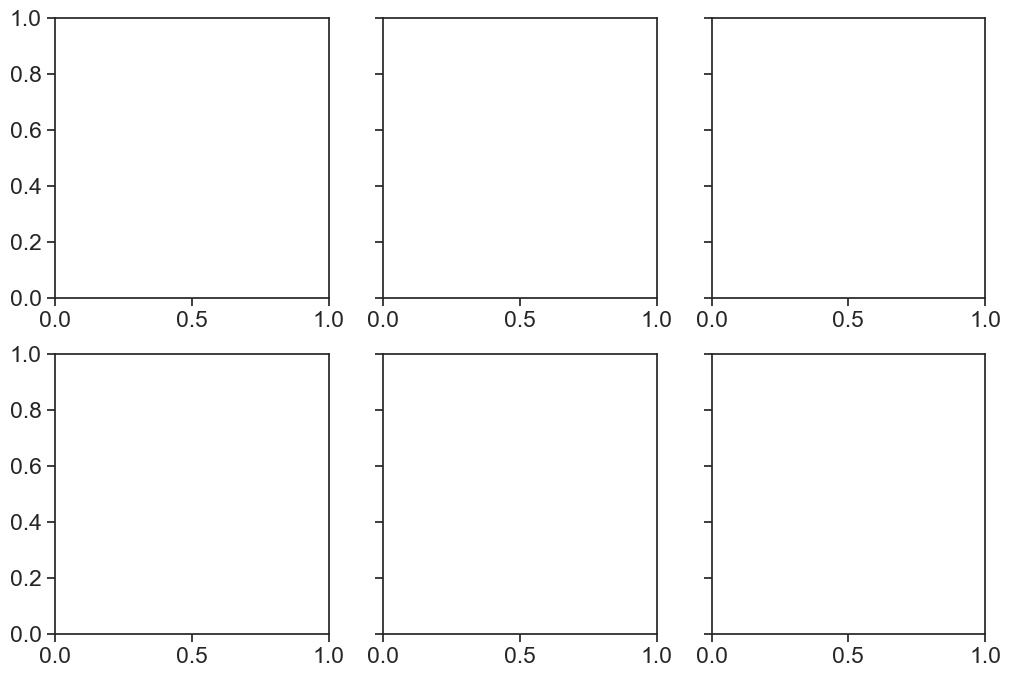

In [361]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
axs = axs.flatten()

nbins = 20

model_names = list(wd.keys()) 
palette = Bold_10.mpl_colors

for i, model_name in enumerate(model_names):
    ax = axs[i]
    resu = wd[model_name]

    # ax.axhline(y=0.5, color='lightgrey', linewidth=1, zorder=0, linestyle='-')

    ################## SE (generated)
    target = 'pe_rao_trans_s_norm'
    y_res, pred, correct_mean_thr = resu[('generated', target)]

    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]

    sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="SE (generated)", color=palette[2], linewidth=2, linestyle='-', ax=ax, zorder=10)
    delta = unsure_count[0]
    
    # baseline (true variability)
    bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    y_res = y_res.sort_values()
    correct_mean_thr = correct_mean_thr.loc[y_res.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]

    sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="SE (baseline)", color=palette[2], linewidth=2, linestyle='--', ax=ax, zorder=10)


    ################## Entropy (generated)
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr = resu[('generated', target)]
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]

    sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="Entropy (generated)", color=palette[3], linewidth=2, linestyle='-', ax=ax, zorder=10)

    # baseline (true variability)
    bs = [int(i) for i in np.linspace(0,len(y_res), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    y_res = y_res.sort_values()
    correct_mean_thr = correct_mean_thr.loc[y_res.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]

    sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="Entropy (baseline)", color=palette[3], linewidth=2, linestyle='--', ax=ax, zorder=10)


    ################## Postilla + KL
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr = resu[('postilla_kl', target)]
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]
    
    sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="Entropy (postilla, KL)", color=palette[0], 
                      linewidth=2, linestyle='-', ax=ax)

    ################## Postilla
    target='answers_entropy_norm'
    y_res, pred, correct_mean_thr = resu[('postilla', target)]
    bs = [int(i) for i in np.linspace(0,len(pred), nbins, endpoint=False)]
    bs_ = [1-np.round(b / len(pred), 2) for b in bs]

    # sort all by predicted
    pred = pd.Series(pred, index=y_res.index, name='pred')
    pred = pred.sort_values()
    y_res = y_res.loc[pred.index]
    correct_mean_thr = correct_mean_thr.loc[pred.index]

    cases_rel = [(len(pred)-b) / len(pred) for b in bs]

    sns.lineplot(x=bs_, y=correctme(correct_mean_thr), label="Entropy (postilla)", color=palette[4], 
                      linewidth=2, linestyle='-', ax=ax)

    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.])
    ax.set_xlabel("Budget")
    if i % 3 == 0:
        ax.set_ylabel("Accuracy")
    else:
        ax.set_ylabel("")
    ax.set_title(model_name)
    ax.get_legend().remove()
    ax.tick_params(labelleft=True)

# Sixth subplot (legend only)
axs[5].axis("off")
handles, labels = axs[0].get_legend_handles_labels()
axs[5].legend(
    handles=handles,
    labels=labels,
    frameon=False,
    loc="center",
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.7,
    handlelength=1.7
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.show()
# plt.savefig("budget_and_baseline_mean_all.pdf", format="pdf", bbox_inches="tight", dpi=600)

In [201]:
y_res

12980    0.00
3650     0.00
9340     0.00
8370     0.00
10150    0.00
         ... 
1071     0.33
1070     0.33
2770     0.54
10061    0.33
10060    0.33
Name: answers_entropy_norm, Length: 1621, dtype: float64

In [202]:
pred

12980    0.010910
3650     0.011665
9340     0.014611
8370     0.015829
10150    0.016284
           ...   
1071     0.374213
1070     0.374213
2770     0.468720
10061    0.496701
10060    0.496701
Name: pred, Length: 1621, dtype: float32

In [205]:
correct_mean_thr

12980     True
3650      True
9340      True
8370      True
10150     True
         ...  
1071     False
1070     False
2770     False
10061     True
10060     True
Name: correct_mean, Length: 1621, dtype: bool

### progressive graph, for all models

In [98]:
!ls ws-*/progressive*.pickle

ws-gemma2b/progressive_window_datagemma-2-2b-it.pickle
ws-gemma9b/progressive_window_datagemma-2-9b-it.pickle
ws-llama/progressive_window_datallama-3.1-8b-instruct.pickle
ws-qwen/progressive_window_dataqwen2.5-7b-instruct.pickle
ws-tablellama/progressive_window_datatablellama.pickle


In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau

import numpy as np

def assessme(y_true, y_pred, printme=False):
    met = {}
    met['mae'] = mean_absolute_error(y_true, y_pred)
    met['mse'] = mean_squared_error(y_true, y_pred)
    met['rmse'] = np.sqrt(met['mse'])
    met['r2'] = r2_score(y_true, y_pred)
    n, k = len(y_true), 1
    met['adj_r2'] = 1 - (1 - met['r2']) * (n - 1) / (n - k - 1)
    met['pearson_corr'], _ = pearsonr(y_true, y_pred)
    met['spearman_corr'], _ = spearmanr(y_true, y_pred)
    met['kendall_corr'], _ = kendalltau(y_true, y_pred) 
    if printme:
        print(f" MAE: {met['mae']}\n MSE: {met['mse']}\n RMSE: {met['rmse']}\n R²: {met['r2']}\n Adjusted R²: {met['adj_r2']}")
    return met

In [100]:
wd = {
    "gemma-2-2b-it": "ws-gemma2b/progressive_window_datagemma-2-2b-it.pickle", 
    "gemma-2-9b-it": "ws-gemma9b/progressive_window_datagemma-2-9b-it.pickle", 
    "llama-3.1-8b-instruct": "ws-llama/progressive_window_datallama-3.1-8b-instruct.pickle",
    "qwen2.5-7b-instruct": "ws-qwen/progressive_window_dataqwen2.5-7b-instruct.pickle", 
    "tablellama": "ws-tablellama/progressive_window_datatablellama.pickle"
}


for k, w in wd.items():
    with open(w, 'rb') as handle:
        wd[k] = pickle.load(handle)

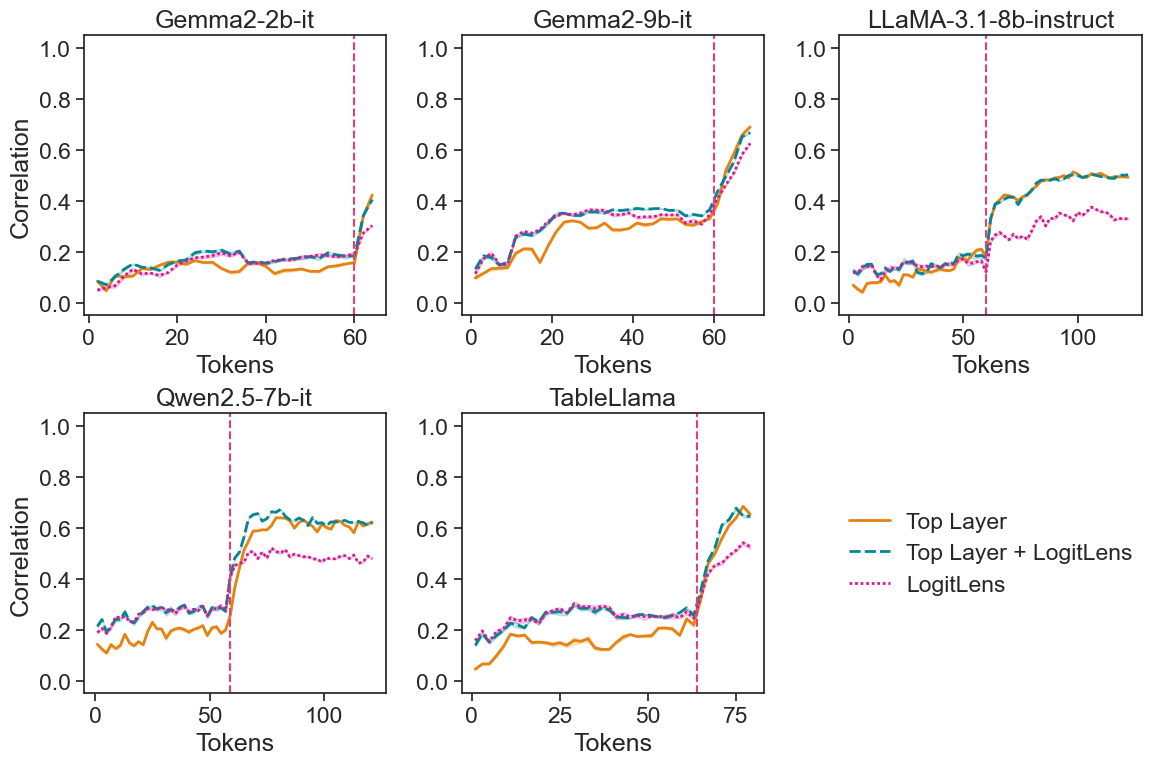

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
from palettable.cartocolors.qualitative import Bold_10
from scipy.ndimage import gaussian_filter1d
import pandas as pd

sns.set_context("notebook", font_scale=1.5)

postilla_shift = {}
postilla_shift['llama-3.1-8b-instruct'] = 60
postilla_shift['gemma-2-2b-it'] = 60
postilla_shift['gemma-2-9b-it'] = 60
postilla_shift['qwen2.5-7b-instruct'] = 59
postilla_shift['tablellama'] = 64

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
axs = axs.flatten()

# define color palette for the 3 src lines
plot_colors = {
    'Top Layer': Bold_10.mpl_colors[6],
    'Top Layer + LogitLens': Bold_10.mpl_colors[7],
    'LogitLens': Bold_10.mpl_colors[8],
}

for i, (model_name, pw) in enumerate(wd.items()):
    ax = axs[i]
    
    aucs = []
    for r, K, pred, y_res in pw['outs_combo']:
        met = assessme(y_res.values, pred)
        aucs.append((r, K, met['spearman_corr']))
    aucs_1 = pd.DataFrame(aucs, columns=['r', 'k', 'spearman_corr'])
    aucs_1['src'] = 'Top Layer'

    aucs = []
    for r, K, pred, y_res in pw['outs_generated_kl']:
        met = assessme(y_res.values, pred)
        aucs.append((r, K, met['spearman_corr']))
    aucs_2 = pd.DataFrame(aucs, columns=['r', 'k', 'spearman_corr'])
    aucs_2['src'] = 'Top Layer + LogitLens'

    aucs = []
    for r, K, pred, y_res in pw['outs_generated_kl_only']:
        met = assessme(y_res.values, pred)
        aucs.append((r, K, met['spearman_corr']))
    aucs_3 = pd.DataFrame(aucs, columns=['r', 'k', 'spearman_corr'])
    aucs_3['src'] = 'LogitLens'

    aucs_ = pd.concat([aucs_1, aucs_2, aucs_3], axis=0)

    sns.lineplot(data=aucs_, x='k', y='spearman_corr', hue='src', palette=plot_colors,
                 linewidth=2, style="src", ax=ax)
    
    model_name_ = model_labels[model_name]
    ax.axvline(postilla_shift[model_name], color=Bold_10.mpl_colors[4], linestyle="--")

    ax.set_title(model_name_)
    ax.set_xlabel("Tokens")
    if i % 3 == 0:
        ax.set_ylabel("Correlation")
    else:
        ax.set_ylabel("")
    ax.get_legend().remove()
    ax.set_ylim(-0.05, 1.05)
    ax.tick_params(labelleft=True)

# Legend in 6th subplot
axs[5].axis("off")
handles, labels = axs[0].get_legend_handles_labels()
axs[5].legend(
    handles=handles,
    labels=labels,
    frameon=False,
    loc="center",
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.7,
    handlelength=1.8
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig("progressive_window_all.pdf", format="pdf", bbox_inches="tight", dpi=600)

### stima dei tempi sulla run con temperatura (in cui non c'è il calcolo delle features)

In [180]:
import os

prefix = 'exp-temperature'
modelname = 'tablellama'

inpath = prefix + '/' + modelname 

outlist = []

for single_file in os.listdir(inpath):
    if 'aggregated' in single_file and 'pickle' in single_file:
        with open(os.path.join(inpath, single_file), 'rb') as handle:
            myfile = pickle.load(handle)
            temperature = single_file.split('_')[-1][:3]
            myfile['temp'] = temperature
            outlist.append(myfile)
            
d = pd.concat(outlist)

In [182]:
d

,pid,answer_clean,cand_clean,regex_match_clean,num_answers,answers_freqs,answers_entropy,answers_entropy_norm,regex_match_freqs,regex_match_entropy,regex_match_entropy_norm,correct,temp
0,13,"[penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label]","[, '- and , '-deuterium-labeled dopamine. synthesis and pharmacologic actions scientific article published on 01 july 1972 scholarly article, sediment chronology in san francisco bay, california, defined by , , , and scholarly article by c.c. fuller et al published february 1999 in marine chemistry scholarly article, sensory neuropathy affects cardiac mirna expression network targeting , , , and mrnas scientific article published on 25 february 2019 scholarly article, new taxa proposed in cryptogamie , mycologie , 38, 2017 scientific article published in december 2017 scholarly article, stereochemistry of low-spin iron porphyrins. i. bis(imidazole)- , , , -tetraphenylporphinatoiron(3) chloride scientific article published on 01 march 1972 scholarly article, 3 framed paintings , 4 unframed paintings , 1 frame painting by mod painting, dan dennett: cute, sexy, sweet, funny ted2009 ted talk, homers odyssee. karl friedr , ameis hentze , carl hentze none scholarly article, still life of newspaper , pipe , dec...","[penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label, penalty recordings american record label record label]",1,[10],0.000000,0.000000,[10],0.000000,0.000000,1.0,0.2
1,14,"[sony bmg former american record company record label, sony bmg former american record company record label, sony music american music company major label, sony bmg former american record company record label, sony music american music company major label, sony music american music company major label, sony music american music company major label, sony music american music company major label, sony music american music company major label, sony bmg former american record company record label]","[sony movie channel american movie-oriented television channel specialty channel, sony mavica digital camera product line digital camera product line, sony u-series subnotebook computers none, sonicstage software software, sony fair none none, sony vision none literary work, sony hdv file format file format, sony lissa range of hifi components by sony none, sony marathi indian marathi-language television channel television channel, template:sony tablet wikimedia template wikimedia template, sony smc-777 none personal computer, sony discos us record label; imprint of sony discos, inc. record label, sony wonder american/canadian record label / sony pictures home entertainment subsidiary record label, sony elephant elephant, sony broadway label by sony music none, sony alpha 290 digital camera model digital camera model, sony channel none none, sony cinealta none none, zn-2 arcade system board arcade system board, hb-f9p home computer home computer, sony hdr-hc1 digital camera model digital camera model, son...","[None, None, sony music american music company major label, None, sony music american mus

In [ ]:
inpath = 'gemma2-9b'
# inpath = 'gemma2-2b'